# 1. Libraries


In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 2. Loading dataset

In [ ]:
# Đọc dữ liệu
file_path = '../data/clean_hcmc_waq.csv'  # Thay bằng đường dẫn file của bạn
data = pd.read_csv(file_path, parse_dates=['date_time'], index_col='date_time')

# Kiểm tra dữ liệu
data.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,cloud_cover,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,us_aqi,weather_status
date_time,,,,,,,,,,,,,,,,,
2022-10-01 07:00:00,25.511000,94.49476,24.561,31.543438,1.3,100.0,0.179606,2.902413,209.74480,61.2,42.1,1123.0,50.80,11.50,4.0,73.652490,Light Rain
2022-10-01 08:00:00,26.411001,88.26100,24.311,31.320229,0.6,100.0,0.403905,9.504272,232.69597,36.9,24.9,906.0,43.05,11.25,14.0,76.471634,Moderate Drizzle
2022-10-01 09:00:00,26.911001,88.03870,24.761,32.211530,0.7,100.0,0.423807,8.788720,214.99210,28.0,18.5,598.0,31.95,10.90,27.0,77.597520,Moderate Drizzle
2022-10-01 10:00:00,28.011000,85.29904,25.311,33.920822,0.6,100.0,0.555415,7.072878,194.74360,24.2,15.9,281.0,19.70,10.50,48.0,78.182625,Moderate Drizzle
2022-10-01 11:00:00,29.011000,78.12226,24.811,34.491055,0.4,100.0,0.875935,7.754637,201.80147,26.0,17.1,213.0,14.25,10.50,67.0,78.430855,Light Drizzle


In [143]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2022-10-01 07:00:00 to 2024-10-01 06:00:00
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   temperature_2m           17544 non-null  float64
 1   relative_humidity_2m     17544 non-null  float64
 2   dew_point_2m             17544 non-null  float64
 3   apparent_temperature     17544 non-null  float64
 4   precipitation            17544 non-null  float64
 5   cloud_cover              17544 non-null  float64
 6   vapour_pressure_deficit  17544 non-null  float64
 7   wind_speed_10m           17544 non-null  float64
 8   wind_direction_10m       17544 non-null  float64
 9   pm10                     17544 non-null  float64
 10  pm2_5                    17544 non-null  float64
 11  carbon_monoxide          17544 non-null  float64
 12  nitrogen_dioxide         17544 non-null  float64
 13  sulphur_dioxide          17544 non-null  

In [ ]:
n_prev_hours = 5

def create_features(data, n_lags=5):
    df = pd.DataFrame()
    for i in range(n_lags):
        df[f'lag_{i+1}'] = data['us_aqi'].shift(i+1)
    df['target'] = data['us_aqi']
    return df.dropna()

# Tạo features và label
df_features = create_features(data)
df_features

,lag_1,lag_2,lag_3,lag_4,lag_5,target
date_time,,,,,,
2022-10-01 12:00:00,78.430855,78.182625,77.597520,76.471634,73.652490,78.625890
2022-10-01 13:00:00,78.625890,78.430855,78.182625,77.597520,76.471634,79.157810
2022-10-01 14:00:00,79.157810,78.625890,78.430855,78.182625,77.597520,79.698586
2022-10-01 15:00:00,79.698586,79.157810,78.625890,78.430855,78.182625,79.991135
2022-10-01 16:00:00,79.991135,79.698586,79.157810,78.625890,78.430855,80.372340
...,...,...,...,...,...,...
2024-10-01 02:00:00,87.411350,89.423770,91.143620,92.854610,94.450356,85.053185
2024-10-01 03:00:00,85.053185,87.411350,89.423770,91.143620,92.854610,82.641846
2024-10-01 04:00:00,82.641846,85.053185,87.411350,89.423770,91.143620,80.824470


In [145]:
X = df_features.iloc[:, :-1].asfreq('h')
y = df_features['target'].asfreq('h')

train_size = len(df_features[df_features.index < '2024-09-01'])
test_size = len(df_features) - train_size

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 16812, Test size: 727


In [ ]:
def train_arima(train, order=(n_prev_hours, 1, 1)):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=test_size)
    return predictions

# Huấn luyện và dự đoán
arima_predictions = train_arima(y_train)
mae_arima = mean_absolute_error(y_test, arima_predictions)
print(f"ARIMA MAE: {mae_arima}")

ARIMA MAE: 14.056993111290575


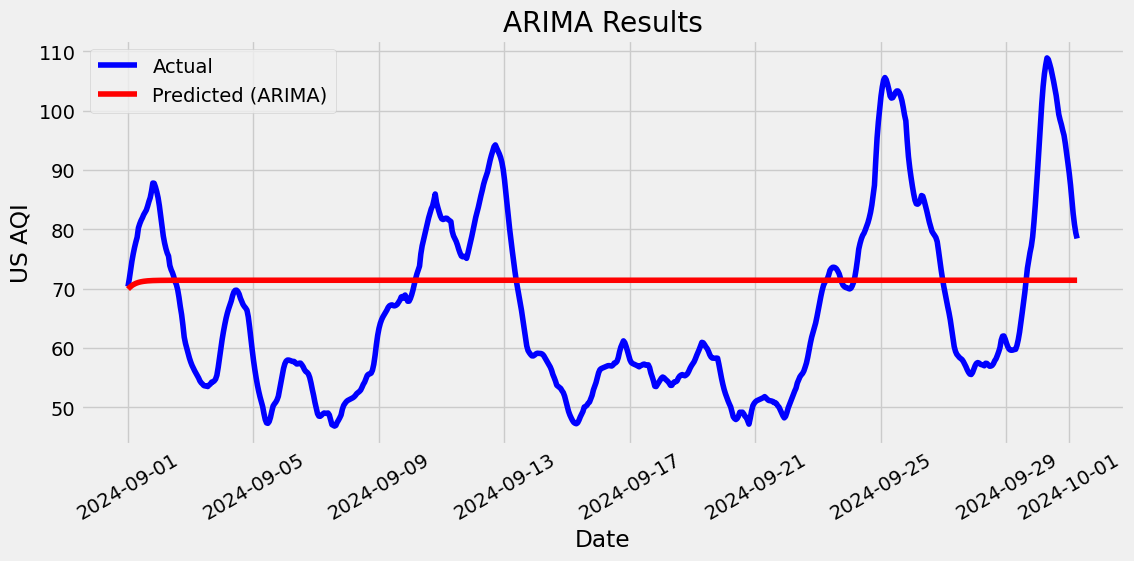

In [147]:
plt.figure(figsize=(12, 5))

plt.plot(y_test, label='Actual', color='blue')
plt.plot(arima_predictions, label='Predicted (ARIMA)', color='red')
plt.xlabel('Date')
plt.ylabel('US AQI')
plt.xticks(rotation=30)
plt.legend()
plt.title('ARIMA Results')
plt.show()

In [ ]:
# Random Forest autoregressive prediction
def autoregressive_rf(model, initial_input, steps):
    predictions = []
    current_input = initial_input.copy()
    for _ in range(steps):
        # Dự đoán bước tiếp theo
        next_pred = model.predict([current_input])[0]
        predictions.append(next_pred)
        # Cập nhật input: bỏ giá trị đầu tiên và thêm giá trị dự đoán
        current_input = np.roll(current_input, -1)
        current_input[-1] = next_pred
    return predictions

# Huấn luyện Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Dự đoán autoregressive
initial_input = X_test.iloc[0].values  # Input ban đầu (từ test set)
rf_predictions_ar = autoregressive_rf(rf_model, initial_input, len(y_test))

/home/van/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/van/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/van/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/van/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/van/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/van/anaconda3/lib/python3.12/

Random Forest Autoregressive MAE: 33.91371891643741


/home/van/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/van/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/van/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/van/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/van/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/van/anaconda3/lib/python3.12/

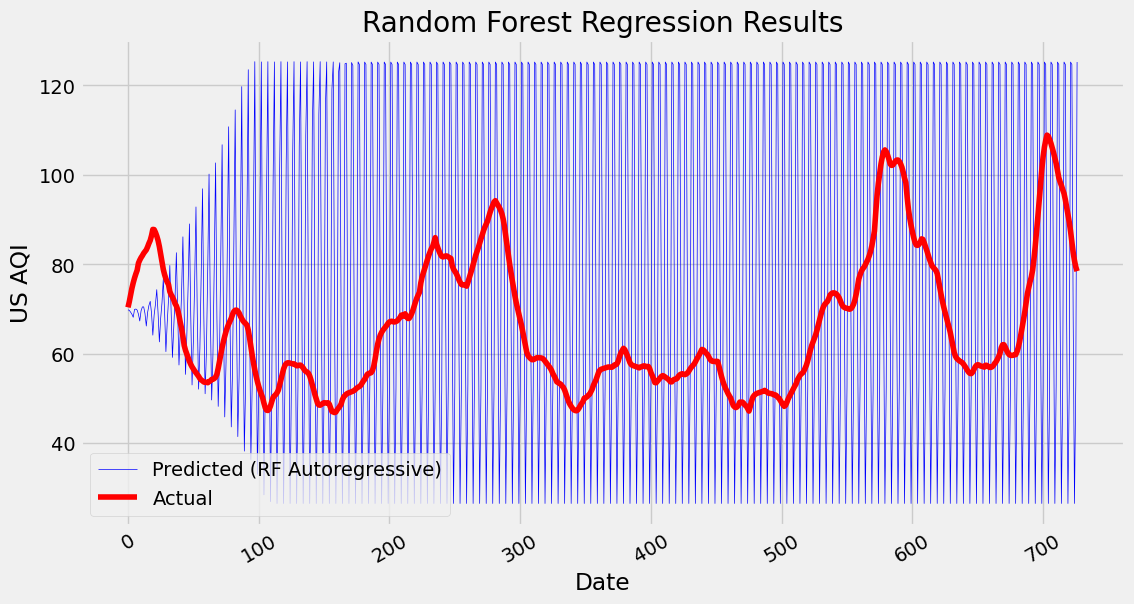

Random Forest Autoregressive 33.91371891643741


In [163]:
plt.figure(figsize=(12, 6)) 
plt.plot(rf_predictions_ar, label='Predicted (RF Autoregressive)', color='blue', linewidth=0.5)
plt.plot(y_test.values, label='Actual', color='red', linewidth=4)
plt.xlabel('Date')
plt.ylabel('US AQI')
plt.xticks(rotation=30)
plt.legend()
plt.title('Random Forest Regression Results')
plt.show()
mae_rf_ar = mean_absolute_error(y_test, rf_predictions_ar)
print('Random Forest Autoregressive',mae_rf_ar)

In [164]:
# Huấn luyện XGBoost
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)


# XGBoost autoregressive prediction
def autoregressive_xgb(model, initial_input, steps):
    predictions = []
    current_input = initial_input.copy()
    for _ in range(steps):
        # Dự đoán bước tiếp theo
        next_pred = model.predict([current_input])[0]
        predictions.append(next_pred)
        # Cập nhật input: bỏ giá trị đầu tiên và thêm giá trị dự đoán
        current_input = np.roll(current_input, -1)
        current_input[-1] = next_pred
    return predictions

# Dự đoán autoregressive
initial_input = X_test.iloc[0].values  # Input ban đầu (từ test set)
xgb_predictions_ar = autoregressive_xgb(xgb_model, initial_input, len(y_test))

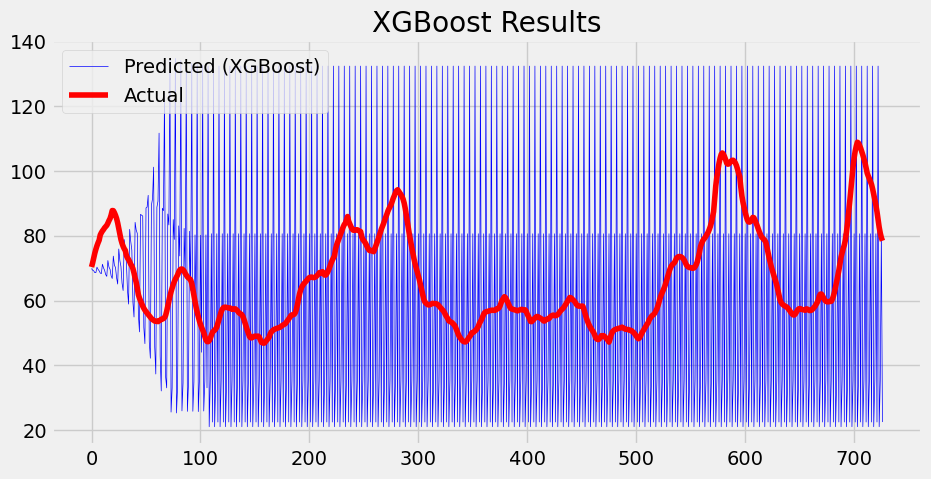

XGBoost MAE: 38.228675666392085


In [167]:
# Visualize
plt.figure(figsize=(10, 5))
plt.plot(xgb_predictions_ar, label='Predicted (XGBoost)', color='blue', linewidth=0.5)
plt.plot(y_test.values, label='Actual', color='red')
plt.legend()
plt.title('XGBoost Results')
plt.show()

mae_xgb = mean_absolute_error(y_test, xgb_predictions_ar)
print(f"XGBoost MAE: {mae_xgb}")

In [178]:
# Chuyển đổi dữ liệu cho LSTM
X_train_lstm = np.expand_dims(X_train.values, axis=-1)
X_test_lstm = np.expand_dims(X_test.values, axis=-1)

# Xây dựng model LSTM
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Huấn luyện
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=1)

# Dự đoán autoregressive với LSTM
def autoregressive_lstm(model, initial_input, steps):
    predictions = []
    current_input = initial_input.copy()  # Input ban đầu (5 giờ trước)
    
    for _ in range(steps):
        # Dự đoán bước tiếp theo
        next_pred = model.predict(current_input.reshape(1, 5, 1))[0][0]
        predictions.append(next_pred)
        
        # Cập nhật input: bỏ giá trị đầu tiên và thêm giá trị dự đoán
        current_input = np.roll(current_input, -1)
        current_input[-1] = next_pred
    
    return predictions

# Dữ liệu đầu vào cho autoregressive LSTM
initial_input_lstm = X_test.iloc[0].values  # Lấy 5 giá trị đầu tiên từ X_test
initial_input_lstm = initial_input_lstm.reshape(5, 1)  # Chuyển thành dạng phù hợp với LSTM

# Dự đoán autoregressive với LSTM
lstm_predictions_ar = autoregressive_lstm(lstm_model, initial_input_lstm, len(y_test))

# Tính toán MAE
mae_lstm_ar = mean_absolute_error(y_test, lstm_predictions_ar)
print(f"LSTM Autoregressive MAE: {mae_lstm_ar}")


Epoch 1/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1042.6594
Epoch 2/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6027
Epoch 3/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6037
Epoch 4/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5695
Epoch 5/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5014
Epoch 6/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5631
Epoch 7/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7479
Epoch 8/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5682
Epoch 9/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6467
Epoch 10/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6018
Epoch 11/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6921
Epoch 12/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6864
Epoch 13/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5332
Epoch 14/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7278
Epoch 15/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step -

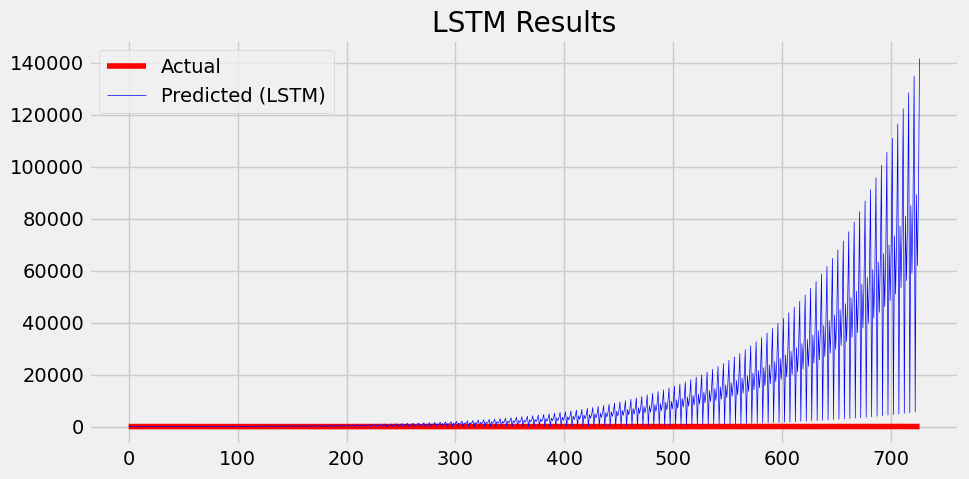

In [184]:
# Visualize
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', color='r')
plt.plot(lstm_predictions_ar, label='Predicted (LSTM)',color='blue', linewidth=0.5)
plt.legend()
# plt.ylim(0,120)
plt.title('LSTM Results')
plt.show()

In [181]:
# Tập hợp độ lỗi các mô hình
results = {
    'ARIMA': mae_arima,
    'Random Forest': mae_rf_ar,
    'XGBoost': mae_xgb,
    'LSTM': mae_lstm_ar
}

# In kết quả
for model, mae in results.items():
    print(f"{model}: MAE = {mae}")

# Chọn mô hình tốt nhất
best_model = min(results, key=results.get)
print(f"Best model: {best_model} with MAE = {results[best_model]}")

ARIMA: MAE = 14.056993111290575
Random Forest: MAE = 33.91371891643741
XGBoost: MAE = 38.228675666392085
LSTM: MAE = 11103.274321906982
Best model: ARIMA with MAE = 14.056993111290575
